In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
from scipy import sparse
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.datasets import make_circles
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

sns.set(style="white")
pd.options.display.float_format = "{:,.2f}".format
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings

warnings.filterwarnings("ignore")

**Spectral Clustering** следует методу соединения, где точки одного кластера либо стоят друг за другом, либо соединены.

**Алгоритм**

<ol>
    <li> Построить матрицу сходства;
        <details>
            <summary>Матрица сходства </summary> <i>Affinity matrix</i> является матрицей взаимного сходства между набором точек данных. Сходство аналогично расстоянию, однако оно не удовлетворяет свойствам метрики: две одинаковые точки будут иметь оценку сходства, равную 1, тогда как вычисление метрики приведет к нулю. Типичными примерами формулы сходства являются <code>cosine similarity</code> и <code>jaccard similarity</code>. Эти формулы сходства можно интерпретировать как вероятность того, что две точки связаны. Например, если две точки данных имеют близкие координаты, то их оценка косинусного сходства (или соответствующая оценка «сродства») будет намного ближе к 1, чем две точки данных с бóльшим пространством между ними.
         </details>
    </li>
    <li> Построить матрицу степеней вершин (degree matrix) $D$ и Матрица Кирхгофа (Laplacian matrix) $L = D - A$;
        <details>
            <summary>Degree matrix</summary> <i>Degree matrix</i> При графе $G = (V, E)$, где $|V| = n$, матрица степени вершин $D$ для $G$ это $n \times n$ диагональная матрица:
            $$D_{i,j} := \begin{cases}
                                deg(v_i) & \text{if } i = j\\
                                0,       & \text{otherwise}
                         \end{cases}$$
            где степень $deg(v_i)$ вершины считается, как количество рёбер графа $G$, инцидентных вершине $v_i$. <a href = https://en.wikipedia.org/wiki/Degree_matrix#Definition>больше</a>
        </details>
        <details>
                <summary>Laplacian matrix</summary> <i>Laplacian matrix</i> одно из представлений конечного графа с помощью матрицы. Матрица Кирхгофа представляет дискретный оператор Лапласа для графа.
            </details>
    </li>
    <li> Найти собственные значения и вектора $L$;</li>
    <li> Построить матрицу из собственных векторов соответствующих $k$ самым большим собственных значений;</li>
    <li> Нормализовать матрицу;</li>
    <li> Кластеризация точек в $k$-размерной плоскости.</li>
</ol>

In [3]:
def spectral_clustering(
    data: np.ndarray,
    n_clusters: int,
    affinity: str,
    n_neighbours: int = 10,
    gamma: float = 1.0,
) -> np.ndarray:
    """ Производит кластеризацию с помощью алгоритма Spectral Clustering
    
    :param data: (n_samples, n_features) данные
    :param n_clusters: количество кластеров
    :param affinity: {'gamma_neigbourhood', 'nearest_neighbour', 'fully_connected'}
                    способ построения матрицы смежности
    :param n_neighbours: количество соседей, когда `affinity = 'nearest_neighbour'`,
                         игнорируется для остальных affinity
    :param gamma: параметр gamma, игнорируется для `affinity = 'nearest_neighbour'`
    :return: (n_samples) лейблы
    """
    # создать матрицу смежности
    affinity_matrix = globals()[affinity](data, n_neighbours=n_neighbours, gamma=gamma)
    
    # создать нормированную матрицу киргрофа
    laplacian = csgraph_laplacian(affinity_matrix, normed=True, return_diag=False)
    laplacian *= -1
    
    # получить `n_clusters` собственных векторов соответствующих
    # `n_clusters` максимальных собственных значений
    _, eigenvectors = eigsh(laplacian, k=n_clusters, sigma=1.0, which="LM")
    
    # кластеризация данных
    k_means = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE).fit(eigenvectors)
    return k_means.labels_

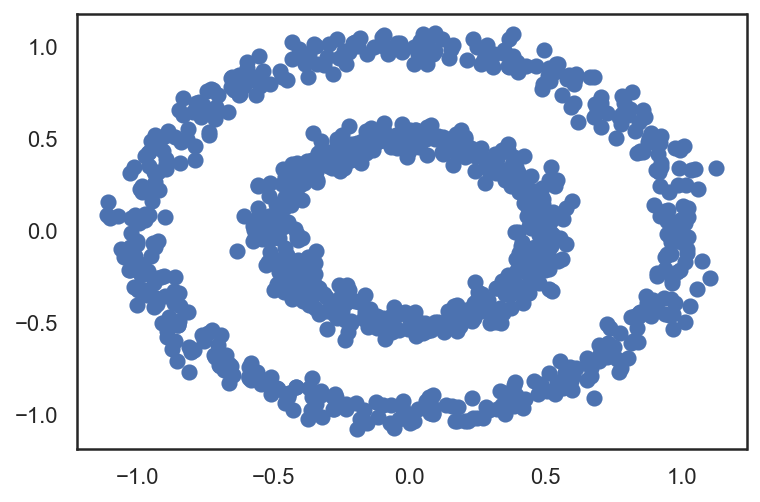

In [4]:
RANDOM_STATE = 0

X, clusters = make_circles(n_samples=1000, noise=.05, factor=.5, random_state=RANDOM_STATE)

plt.scatter(X[:, 0], X[:, 1], s=50, c="b")
plt.show()

При графе $G = (V, E)$, матрица сходства будет матрицей смежности или матрицей весов ребер между вершинами.

Основная задача определить, есть ли между вершинами ребро. Это делается разными методами ([статья](https://www.cs.cmu.edu/~aarti/Class/10701/readings/Luxburg06_TR.pdf)):
- **$\epsilon$-neighbourhood graph**: мы определяем ребро между вершинами, если расстояние между вершинами меньше $\epsilon$. Т.к. расстояния между вершинами будет примерно $\epsilon$, матрица сходства будет представлена в виде матрицы смежности;
- **$k$-nearest neighbour graph**: мы соединяем вершину $v_i$ к вершине $v_j$, если вершина $v_j$ среди $k$ ближайших соседей $v_i$.
- **fully connected graph**: все вершины соединяются если имеют положительную схожесть с весом $s_{ij} = \exp(- \|v_i - v_j \|^2 * \sigma)$

In [5]:
def gamma_neigbourhood(data: np.ndarray, n_neighbours: int, gamma: float) -> np.ndarray:
    """ Построение матрицы смежности с помощью gamma_neigbourhood
    
    мы определяем ребро между вершинами, если расстояние между вершинами меньше `gamma`
    
    :param data: (n_samples, n_features) данные
    :param n_neighbours: не используется
    :param gamma: максимальное расстояние между вершинами, чтобы существовало ребро
    :return: (n_samples, n_samples) матрица смежности
    """
    distance = cdist(data, data)
    affinity_matrix = np.where(distance < gamma, 1, 0)
    
    return affinity_matrix

In [6]:
def nearest_neighbour(data: np.ndarray, n_neighbours: int, gamma: float) -> np.ndarray:
    """ Построение матрицы смежности с помощью nearest_neighbour
    
    мы соединяем вершину `х` и `у`, вершина у среди `n_neighbours` ближайших соседей 
    
    :param data: (n_samples, n_features) данные
    :param n_neighbours: количество соседей
    :param gamma: не используется
    :return: (n_samples, n_samples) матрица смежности
    """
    affinity_matrix = np.zeros((data.shape[0], data.shape[0]))
    
    distance = cdist(data, data)
    neighbours = np.argpartition(distance, n_neighbours, axis=1)[:, :n_neighbours]
    
    for vertex_i in range(neighbours.shape[0]):
        affinity_matrix[vertex_i, neighbours[vertex_i]] = 1
        
    affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)
        
    return affinity_matrix

In [7]:
def fully_connected(data: np.ndarray, n_neighbours: int, gamma: float) -> np.ndarray:
    """ Построение матрицы смежности с помощью fully_connected
    
    все вершины соединяются если имеют положительную схожесть с весом `exp(-||x-y||**2 * gamma)
    
    :param data: (n_samples, n_features) данные
    :param n_neighbours: не используется
    :param gamma: максимальное расстояние между вершинами, чтобы существовало ребро
    :return: (n_samples, n_samples) матрица смежности
    """
    distance = cdist(data, data)
    affinity_matrix = np.exp(- distance * gamma)

    return affinity_matrix

In [8]:
def plot_resulted_clusters(
    data: np.ndarray,
    labels: np.ndarray,
    n_row_plots: int,
    n_column_plots: int,
    n_plot: int,
    affinity: str = 'fully_connected',
    assign_labels: str = 'kmeans'
):
    """ Отрисовка данных с разными параметрами

    :param data: (n_samples, n_features) данные
    :param labels: (n_samples) лейблы
    :param n_row_plots: количество графиков в строке
    :param n_column_plots: количество графиков в колонке
    :param n_plot: номер графика
    :param affinity: 
    :param assign_labels: 
    """   
    plt.subplot(n_row_plots, n_column_plots, n_plot)
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, s=50, cmap='viridis')
    plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1])
    plt.title(f'Результат кластеризации\n{affinity}\n{assign_labels}')

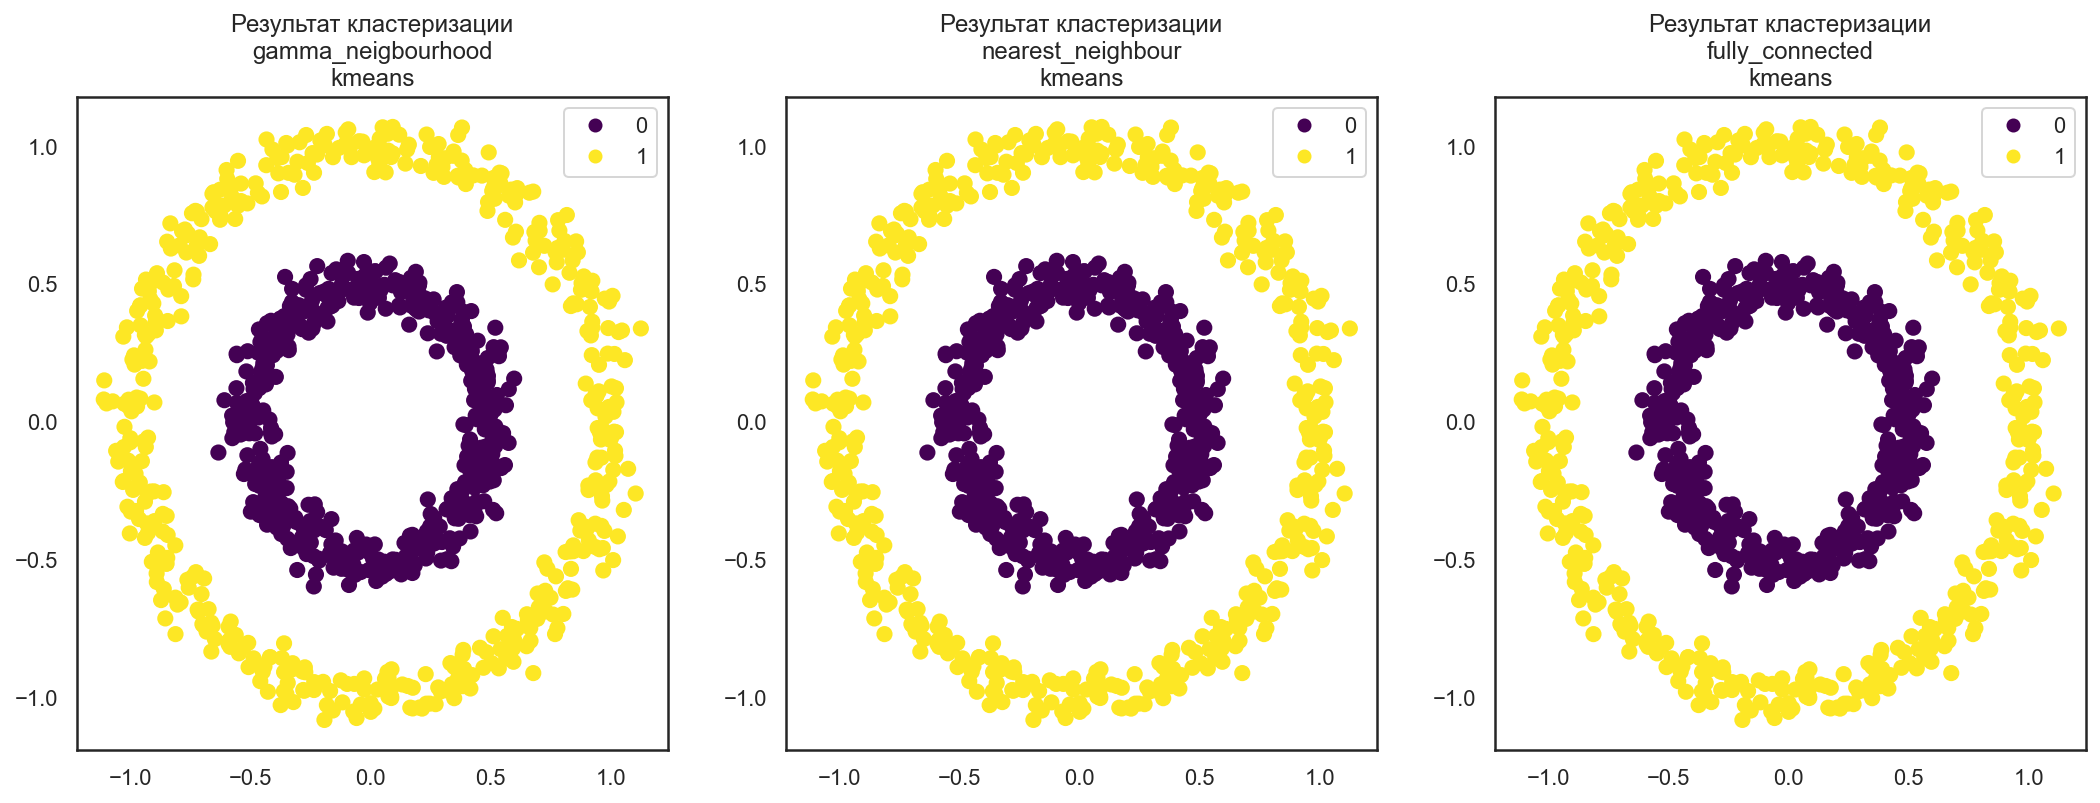

In [9]:
affinity_params = ['gamma_neigbourhood', 'nearest_neighbour', 'fully_connected']
params = [[0.1, 10], [1, 10], [50, 10]]

n_column_plots, n_row_plots = len(affinity_params), 1
plt.figure(figsize=(n_column_plots * 6, n_row_plots * 6))

for n_plot, affinity in enumerate(affinity_params):
    labels = spectral_clustering(X, n_clusters=2, affinity=affinity,
                                 n_neighbours=params[n_plot][1], gamma=params[n_plot][0])
    plot_resulted_clusters(X, labels, n_row_plots=n_row_plots,
                           n_column_plots=n_column_plots, n_plot=n_plot+1, affinity=affinity)

После получения матрицы собственных векторов, мы производим присвоение кластеров:
- с помощью алгоритма $k$-means;
- с помощью алгоритма [discretize](https://www1.icsi.berkeley.edu/~stellayu/publication/doc/2003kwayICCV.pdf):
    1. Посчитать матрицу степеней вершин $D$;
    2. Найти оптимальное eigensolution $Z^*$ с помощью $$D^{-\frac{1}{2}}WD^{-\frac{1}{2}} \bar{V}_{[K]} = \bar{V}_{[K]} Diag(s_{[K]})$$ $$\bar{V}_{[K]}^T \bar{V}_{[K]} = I_K$$ $$Z^* = D^{-\frac{1}{2}} \bar{V}_{[K]}$$
    3. Нормализовать $Z^*$ $\tilde{X}^* = Diag(diag^{-\frac{1}{2}}(Z^*Z^{*T}))Z^*$;
    4. Инициадизировать $X^*$, посчитав $$R^* = [\tilde{X}^*(i, 1),\dots \tilde{X}^*(i, K)]^T, \text{random } i\in N$$ $$c=0_{N\times1}$$ $$\text{For } k=2,\dots, K \text{ do}:\\ c=c+abs(\tilde{X}^* R^*_{k-1})\\ R^*_k=[\tilde{X}^*(i, 1),\dots \tilde{X}^*(i, K)]^T, i=arg \min c$$
    5. Инициализировать параметр сходимости $\bar{\phi}^*=0$
    6. Найти оптимальное дискретное решение $X*$ $$\tilde{X} = \tilde{X}^* R^*$$ $$X^*(i,l) = \langle l= arg \max_{k\in[K]} \tilde{X}(i,k)\rangle, i\in V, l \in [K]$$
    7. Найти оптимальную ортнормированную матрицу $R^*$ $$X^{*T}\tilde{X}^* = U \Omega \tilde{U}, \quad \Omega = Diag(\omega)$$ $$\bar{\phi} = tr(\Omega)$$ $$\text{If } |\bar{\phi} - \bar{\phi}^*| < \text{ machine precision, then stop and output } X^*$$ $$\bar{\phi}^* = \bar{\phi}$$ $$R^* = \tilde{U}U^T$$
    8. Перейти к шагу 6.

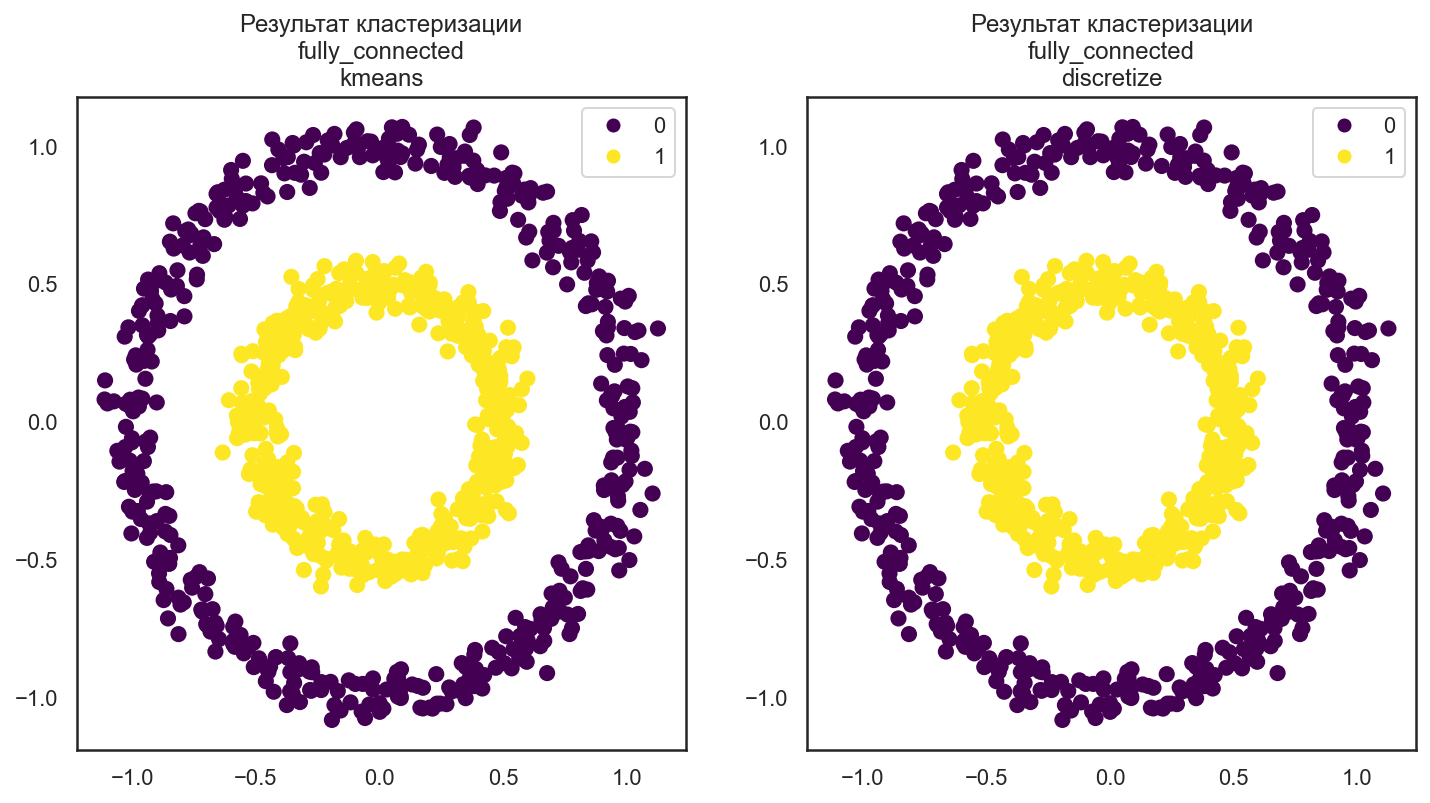

In [10]:
assign_labels_params = ['kmeans', 'discretize']

n_column_plots, n_row_plots = len(assign_labels_params), 1
plt.figure(figsize=(n_column_plots * 6, n_row_plots * 6))

for n_plot, assign_labels in enumerate(assign_labels_params):
    clustering = SpectralClustering(n_clusters=2, assign_labels=assign_labels, gamma=50, random_state=RANDOM_STATE).fit(X)
    plot_resulted_clusters(X, clustering.labels_, n_row_plots=n_row_plots,
                           n_column_plots=n_column_plots, n_plot=n_plot+1, assign_labels=assign_labels)

Эта [статья](https://www.kyb.tuebingen.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5B0%5D.pdf) предлагает один из способов нахождения оптимального количества кластеров. Eigengap метрика предлагает число кластеров `n_clusters` являться таким значением, которое максимизирует eigengap. Чес больше eigengap, тем ближе собственные значения идеального решения

<details>
    <summary> Eigengap</summary> разница между соседними собственными значениями
</details>

2

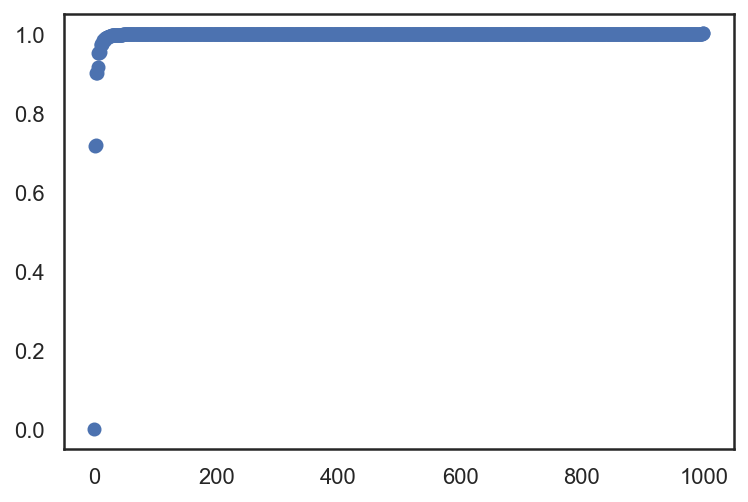

In [11]:
affinity_matrix = fully_connected(X, n_neighbours=10, gamma=1.)

laplacian = csgraph_laplacian(affinity_matrix, normed=True, return_diag=False)
eigenvalues, eigenvectors = eigsh(laplacian.T, k=X.shape[0], sigma=1.0, which="LM")

plt.scatter(np.arange(len(eigenvalues)), eigenvalues)

index_largest_gap = np.argmax(np.diff(eigenvalues))
n_clusters = index_largest_gap + 2

n_clusters

**Итог**

| Параметры | Плюсы | Минусы |
| :-------- | :---- | :----- |
| - `n_clusters`: количество кластеров;<br> - `affinity`: способ построения матрицу сходства;<br> - `assign_labels`: способ присвоения лейблов | - хорошая эффективность;<br> - легко имплементировать;<br> - может работать с кластерами разных форм | - выбор количество кластеров перед началом алгоритма;<br> - не советуют использовать для большого количества кластеров.